In [1]:
import pandas as pd

# Load the datasets
customers_df = pd.read_csv('Customers.csv')
print()
products_df = pd.read_csv('Products.csv')
print()
transactions_df = pd.read_csv('Transactions.csv')

# Check the first few rows of the data
customers_df.head(), products_df.head(), transactions_df.head()

(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   ProductID              ProductName     Category   Price
 0      P001     ActiveWear Biography        Books  169.30
 1      P002    ActiveWear Smartwatch  Electronics  346.30
 2      P003  ComfortLiving Biography        Books   44.12
 3      P004            BookWorld Rug   Home Decor   95.69
 4      P005          TechPro T-Shirt     Clothing  429.31,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55    

In [2]:
# Calculate total spend per customer
total_spend = transactions_df.groupby('CustomerID')['TotalValue'].sum().reset_index()
total_spend.rename(columns={'TotalValue': 'TotalSpend'}, inplace=True)

# Merge the total spend data with customers
customers_df = pd.merge(customers_df, total_spend, on='CustomerID', how='left')

# Frequency of transactions per product category
transaction_category_freq = transactions_df.merge(products_df, on='ProductID', how='left')
transaction_category_freq = transaction_category_freq.groupby(['CustomerID', 'Category']).size().unstack(fill_value=0)

# Merge transaction frequencies with the customer data
customers_df = pd.merge(customers_df, transaction_category_freq, on='CustomerID', how='left')
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CustomerID    200 non-null    object 
 1   CustomerName  200 non-null    object 
 2   Region        200 non-null    object 
 3   SignupDate    200 non-null    object 
 4   TotalSpend    199 non-null    float64
 5   Books         199 non-null    float64
 6   Clothing      199 non-null    float64
 7   Electronics   199 non-null    float64
 8   Home Decor    199 non-null    float64
dtypes: float64(5), object(4)
memory usage: 14.2+ KB


In [3]:
customers_df=customers_df.dropna()
customers_df.isna().sum()

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
TotalSpend      0
Books           0
Clothing        0
Electronics     0
Home Decor      0
dtype: int64

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

# Extract the features (excluding CustomerID and Region)
feature_columns = ['TotalSpend'] + list(transaction_category_freq.columns)
customer_features = customers_df[feature_columns]

# Normalize the data (optional, but recommended for similarity measures)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features)

# Compute cosine similarity
similarity_matrix = cosine_similarity(customer_features_scaled)

# Create a DataFrame with similarity scores
similarity_df = pd.DataFrame(similarity_matrix, index=customers_df['CustomerID'], columns=customers_df['CustomerID'])


In [5]:
# Function to get top 3 lookalikes for each customer
def get_top_lookalikes(similarity_df, top_n=3):
    lookalikes = {}
    for customer_id in similarity_df.index:
        # Get the similarity scores for the customer, sort by highest scores
        similar_customers = similarity_df[customer_id].sort_values(ascending=False).head(top_n+1).iloc[1:]
        lookalikes[customer_id] = [(customer, score) for customer, score in zip(similar_customers.index, similar_customers.values)]
    return lookalikes

# Get the top 3 lookalikes
lookalikes = get_top_lookalikes(similarity_df)

# Save the lookalike recommendations to a CSV file
flattened_lookalikes = []
for customer_id, recommendations in lookalikes.items():
    for lookalike_customer, score in recommendations:
        flattened_lookalikes.append([customer_id, lookalike_customer, score])

# Convert the list into a DataFrame
lookalikes_df = pd.DataFrame(flattened_lookalikes, columns=['CustomerID', 'Lookalike_CustomerID', 'Similarity_Score'])

In [6]:
lookalikes_df.head()

,CustomerID,Lookalike_CustomerID,Similarity_Score
0,C0001,C0069,0.947427
1,C0001,C0127,0.896290
2,C0001,C0035,0.866625
3,C0002,C0133,0.966664
4,C0002,C0134,0.916734


In [7]:
mean_similarity_score = lookalikes_df['Similarity_Score'].mean()
print(f'Mean Similarity Score: {mean_similarity_score}')

Mean Similarity Score: 0.9150597783873168


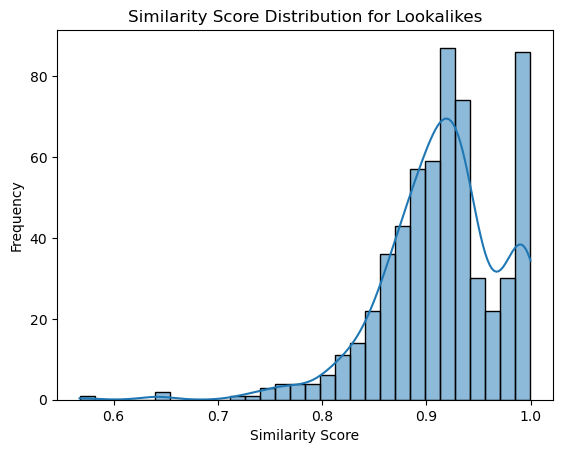

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the similarity score distribution
sns.histplot(lookalikes_df['Similarity_Score'], bins=30, kde=True)
plt.title('Similarity Score Distribution for Lookalikes')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()


In [9]:
# Save the reshaped data to a CSV file
lookalikes_df.to_csv('Greeshma_Haridas_Lookalike.csv', index=False)